## Rainbow DQN

[Rainbow DQN](https://arxiv.org/pdf/1710.02298) 结合了DQN算法的6个扩展改进，其中包括DDQN，Dueling DQN，Prioritized Replay、Multi-step Learning、Distributional RL、Noisy Net，再加上基础的DQN，凑齐七种因素，召唤神龙Rainbow！具体如下：

* 🎲 NoisyNet: 替代 ε-greedy，实现探索
* 🧠 Dueling DQN: 分离 value 与 advantage
* 📊 Categorical DQN: 用分布来逼近 Q 值
* 🔁 Double DQN: 减少过估计
* 🧪 PER (Prioritized Experience Replay): 优先采样
* 🔄 N-step Learning: 多步回报

### 定义模型

这里网络部分将Dueling DQN、Distributional RL、Noisy Net结合在了一起，即用NoisyLinear替代了普通的线性层、将单个

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class NoisyLinear(nn.Module):
    def __init__(self, input_dim, output_dim, std_init=0.4):
        super(NoisyLinear, self).__init__()
        
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.std_init     = std_init
        
        self.weight_mu    = nn.Parameter(torch.FloatTensor(output_dim, input_dim))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(output_dim, input_dim))
        self.register_buffer('weight_epsilon', torch.FloatTensor(output_dim, input_dim))
        
        self.bias_mu    = nn.Parameter(torch.FloatTensor(output_dim))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(output_dim))
        self.register_buffer('bias_epsilon', torch.FloatTensor(output_dim))
        
        self.reset_parameters()
        self.reset_noise()
    
    def forward(self, x):
        # 只有在训练的时候需要使用噪声探索，测试时使用均值即可
        if self.training: 
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias   = self.bias_mu   + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias   = self.bias_mu
        return F.linear(x, weight, bias)
    
    def reset_parameters(self):
        mu_range = 1 / math.sqrt(self.weight_mu.size(1))
        
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.weight_sigma.size(1)))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.bias_sigma.size(0)))
    
    def reset_noise(self):
        epsilon_in  = self._scale_noise(self.input_dim)
        epsilon_out = self._scale_noise(self.output_dim)
        
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.output_dim))
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        x = x.sign().mul(x.abs().sqrt())
        return x

class Model(nn.Module):
    def __init__(self, cfg, state_dim, action_dim, hidden_dim=256):
        """ 初始化q网络，为全连接网络
        """
        super(Model, self).__init__()
        self.n_atoms = cfg.n_atoms
        self.action_dim = action_dim
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU()
        )
        # 这里分成两部分，分别是advantage和value, 即Dueling DQN的结构
        self.advantage = nn.Sequential(
            NoisyLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            NoisyLinear(hidden_dim, action_dim * self.n_atoms)
        )

        self.value = nn.Sequential(
            NoisyLinear(hidden_dim, hidden_dim),
            nn.ReLU(),
            NoisyLinear(hidden_dim, self.n_atoms)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value(x).view(-1, 1, self.n_atoms) # (batch_size, 1, n_atoms)
        advantage = self.advantage(x).view(-1, self.action_dim, self.n_atoms) # (batch_size, a_dim, n_atoms)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True) # (batch_size, a_dim, n_atoms)
        dist = torch.softmax(q_atoms, dim=-1)
        # dist = torch.log_softmax(q_atoms, dim=-1)
        return dist
    
    def reset_noise(self):
        for module in self.modules():
            if isinstance(module, NoisyLinear):
                module.reset_noise()



### 定义经验回放

直接复用PER DQN的实现即可

In [26]:
import numpy as np

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_idx, priority)
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

    def update(self, tree_idx, priority):
        change = priority - self.tree[tree_idx]
        self.tree[tree_idx] = priority
        while tree_idx != 0:
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v):
        parent_idx = 0
        while True:
            left_child_idx = 2 * parent_idx + 1
            right_child_idx = left_child_idx + 1
            if left_child_idx >= len(self.tree):
                leaf_idx = parent_idx
                break
            else:
                if v <= self.tree[left_child_idx]:
                    parent_idx = left_child_idx
                else:
                    v -= self.tree[left_child_idx]
                    parent_idx = right_child_idx
        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]
    
    @property
    def max_priority(self):
        return self.tree[-self.capacity:].max()
        
    @property
    def total_priority(self):
        return self.tree[0]

class ReplayBuffer:
    def __init__(self, cfg):
        self.capacity = cfg.buffer_size
        self.alpha = cfg.per_alpha
        self.beta = cfg.per_beta
        self.beta_increment_per_sampling = cfg.per_beta_increment_per_sampling
        self.epsilon = cfg.per_epsilon
        self.tree = SumTree(self.capacity)
        
    def push(self, transition):
        # max_prio = self.tree.tree[-self.tree.capacity:].max()
        max_prio = self.tree.max_priority
        if max_prio == 0:
            max_prio = 1.0
        self.tree.add(max_prio, transition)

    def sample(self, batch_size):
        self.beta = min(1.0, self.beta + self.beta_increment_per_sampling)
        minibatch = []
        idxs = []
        segment = self.tree.total_priority / batch_size
        priorities = []

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = np.random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            minibatch.append(data)
            idxs.append(idx)
            priorities.append(p)

        sampling_probabilities = priorities / self.tree.total_priority
        is_weight = np.power(self.tree.capacity * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        batch = list(zip(*minibatch))
        return tuple(map(lambda x: np.array(x), batch)), idxs, is_weight

    def update_priorities(self, idxs, priorities):
        for idx, priority in zip(idxs, priorities):
            self.tree.update(idx, (np.abs(priority) + self.epsilon) ** self.alpha)

    def __len__(self):
        return len(self.tree.data)

### 定义策略


智能体主要负责与环境交互并更新策略(模型参数)，因此首先需要定义sample_action和predict_action两个函数，前者用于训练时的采样动作，一般会采取$\varepsilon-\text{greedy}$策略来提高探索能力，后者一般用于测试算法时的预测动作。其次需要定义update函数，这个函数主要用来从经验回放中采样样本，然后更新模型参数。

注意：
* 每个张量的维度要对应上，否则可能会报错或者不收敛

In [ ]:
import random
import torch
import torch.optim as optim
import math
import numpy as np

class Policy:
    def __init__(self, cfg):
        self.action_dim = cfg.action_dim  # 动作空间的维度
        self.v_min = cfg.v_min # C51原子的最小值
        self.v_max = cfg.v_max # C51原子的最大值
        self.tau = cfg.tau # 软更新的参数
        self.gamma = cfg.gamma # 奖励的折扣因子
        self.batch_size = cfg.batch_size # 批量大小
        self.device = torch.device(cfg.device) # CPU或GPU 
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.n_atoms = cfg.n_atoms # C51的原子数
        self.atoms = torch.linspace(cfg.v_min, cfg.v_max, steps= self.n_atoms, device = self.device) # support
        self.proj_dist = torch.zeros((self.batch_size, self.n_atoms), device = self.device) # [batch_size, n_atoms]
        self.memory = ReplayBuffer(cfg)
        # 当前网络和目标网络
        self.model = Model(cfg, cfg.state_dim, cfg.action_dim, hidden_dim =  cfg.hidden_dim).to(self.device) # 当前或在线网络
        self.target_model = Model(cfg, cfg.state_dim, cfg.action_dim, hidden_dim = cfg.hidden_dim).to(self.device) # 目标网络
        self.target_model.load_state_dict(self.model.state_dict()) # 复制参数到目标网络
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.lr) # 优化器
        self.update_cnt = 0 # 用于延迟更新目标网络的计数
        
    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            action = self.predict_action(state)
        else:
            action = random.randrange(self.action_dim)
        return action
    
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()：
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0) # [1, state_dim]
        dist = self.model(state)
        q_values = (dist * self.atoms).sum(2)
        action = torch.argmax(q_values).detach().cpu().numpy().item()
        return action
    
    def get_policy_params(self):
        ''' 获取当前策略的参数
        '''
        return self.model.state_dict()
    
    def load_policy_params(self, params):
        ''' 加载策略参数
        '''
        self.model.load_state_dict(params)
    
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()：
    def projection_distribution(self, next_states, rewards, dones):
        ''' 用于计算下一时刻的分布
        '''
        delta_z = float(self.v_max - self.v_min) / (self.n_atoms - 1)
        next_dist = self.target_model(next_states) # [batch_size, action_dim, n_atoms]
        next_q_values = (next_dist * self.n_atoms).sum(2) # [batch_size, action_dim]
        next_dist = next_dist[torch.arange(self.batch_size), torch.argmax(next_q_values, dim=1)]
        Tz = rewards + (1-dones) * self.gamma * self.atoms
        Tz = Tz.clamp(min=self.v_min, max=self.v_max)
        b = (Tz - self.v_min) / delta_z
        l = b.floor().long()
        u = b.ceil().long()
        delta_m_l = (u + (l == u) - b) * next_dist  # (batch_size, n_atoms)
        delta_m_u = (b - l) * next_dist # (batch_size, n_atoms)
        offset = torch.linspace(0, (self.batch_size - 1) * self.n_atoms, self.batch_size,device=self.device).unsqueeze(-1).long() 
        self.proj_dist *= 0
        self.proj_dist.view(-1).index_add_(0, (l + offset).view(-1), delta_m_l.view(-1))
        self.proj_dist.view(-1).index_add_(0, (u + offset).view(-1), delta_m_u.view(-1))

    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的样本
        (states, actions, rewards, next_states, dones), idxs, weights = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        states = torch.tensor(np.array(states), device=self.device, dtype=torch.float) # [batch_size, state_dim]
        actions = torch.tensor(actions, device=self.device, dtype=torch.int64).unsqueeze(1)  #  [batch_size, 1]
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float).unsqueeze(1)   # [batch_size, 1]
        next_states = torch.tensor(np.array(next_states), device=self.device, dtype=torch.float) # [batch_size, state_dim]
        dones = torch.tensor(np.float32(dones), device=self.device).unsqueeze(1)  # [batch_size,1]
        weights = torch.tensor(weights, device=self.device, dtype=torch.float).unsqueeze(1) # [B,1]
        # 计算下一时刻的分布
        self.projection_distribution(next_states, rewards, dones)
        # 计算当前状态的分布
        dist = self.model(states) # [batch_size, action_dim, n_atoms]
        dist = dist.gather(1, actions.unsqueeze(1).expand(self.batch_size, 1, self.n_atoms)).squeeze(1) # [batch_size, n_atoms]
        # dist = dist[torch.arange(self.batch_size), actions.squeeze(1).cpu().numpy()] # [batch_size, n_atoms]
        # action_ = actions.unsqueeze(1).expand(self.batch_size, 1, self.n_atoms)
        # dist = dist.gather(1, action_).squeeze(1) # [batch_size, n_atoms]
        # dist.data.clamp_(0.01, 0.99) # 为了数值稳定，将概率值限制在[0.01, 0.99]之间
        loss = -(self.proj_dist * dist.clamp(min=1e-5, max=1 - 1e-5).log()).sum(-1) # [batch_size, n_atoms]
        loss = (loss * weights).mean() # [batch_size, n_atoms]

        td_errors = (dist * self.atoms).sum(1) - (self.proj_dist * self.atoms).sum(1)# 计算TD误差
        priorities = td_errors.squeeze().cpu().detach().numpy() + 1e-5 # 计算TD误差
        # 需要更新样本的优先度
        self.memory.update_priorities(idxs, priorities) 
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        # for param in self.model.parameters():  
        #     param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        self.update_cnt += 1
        # 每隔一定步数更新目标网络的参数
        # 软更新
        for param, target_param in zip(self.model.parameters(), self.target_model.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        
        self.model.reset_noise() # 重置当前网络的噪声
        self.target_model.reset_noise() # 重置目标网络的噪声

### 设置参数和定义可视化函数

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线, 类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    allow_types = ['int', 'float', 'str', 'bool', 'list', 'dict']
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        if v.__class__.__name__ not in allow_types:
            continue
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

class Config:
    def __init__(self) -> None:
        self.algo_name = 'C51' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.mode = 'train'
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda' # 使用cpu还是gpu
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.max_epsiode = 200 # 训练的回合数
        self.max_epsiode_test = 20 # 测试的回合数
        self.max_step = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.99 # 折扣因子
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500 # e-greedy策略中epsilon的衰减率
        self.hidden_dim = 256 # 神经网络的隐藏层维度
        self.batch_size = 256 # 批次大小
        self.target_update = 200 # 目标网络的更新频率
        self.n_steps = 2 # 每n步更新一次策略
        self.n_iter_per_update = 2 # 每次更新策略的迭代次数
        self.lr = 0.0001 # 学习率
        self.tau = 0.005 # 软更新参数
        #region buffer相关参数
        self.buffer_size = 100000 # 经验回放池的容量
        self.per_alpha = 0.6 # 优先级的指数 
        self.per_epsilon = 1e-5 # 优先级的最小值
        self.per_beta = 0.4 # beta的初始值
        self.per_beta_increment_per_sampling = 0.0001 # beta的增量
        #endregion
        #region C51相关参数
        self.n_atoms = 51 # 原子个数
        self.v_min = -100 # 原子的最小值
        self.v_max = 100 # 原子的最大值
        #endregion
        self.reward_threshold = 200 # 奖励阈值，达到该值则认为训练成功
        self.reward_threshold_limit = 10 # 累计一定训练成功次数后停止训练, 这样可以避免训练过长时间

### 定义训练

In [29]:

import gymnasium as gym

def make_env(cfg: Config):
    ''' 创建环境
    '''
    env = gym.make(cfg.env_id) # 创建环境
    setattr(cfg, "action_space", env.action_space) # 动作空间
    setattr(cfg, "state_dim", env.observation_space.shape[0]) # 状态维度
    setattr(cfg, "action_dim", env.action_space.n) # 动作维度
    return env

def train(cfg: Config, env, policy):
    ''' 训练
    '''
    rewards = []  # 记录所有回合的奖励
    best_policy_params = None  # 最佳策略
    best_ep_reward = float('-inf') # 最佳回合的奖励
    reward_threshold_cnt = 0 # 奖励阈值计数器
    frames = []
    tot_step = 0
    for i_ep in range(cfg.max_epsiode):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_step):
            ep_step += 1
            tot_step += 1
            action = policy.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward, next_state, float(truncated or terminated)))   # 保存transition
            state = next_state  # 更新下一个状态
            if tot_step%cfg.n_steps == 0: # 每n步更新一次策略
                for _ in range(cfg.n_iter_per_update):
                    policy.update()  
            ep_reward += reward  # 累加奖励
            if terminated:
                if ep_reward >= best_ep_reward:  # 更新最佳策略
                    best_ep_reward = ep_reward
                    best_policy_params = policy.model.state_dict()
                    print(f"更新最佳策略，回合：{i_ep+1}/{cfg.max_epsiode}, 最佳奖励：{best_ep_reward:.2f}")
                if ep_reward >= cfg.reward_threshold:
                    reward_threshold_cnt += 1
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        if reward_threshold_cnt >= cfg.reward_threshold_limit:
            print(f"达到奖励阈值累计{cfg.reward_threshold_limit}次, 训练成功，回合：{i_ep+1}/{cfg.max_epsiode}，奖励：{ep_reward:.2f}")
            break
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.max_epsiode}，奖励：{ep_reward:.2f}, Epislon: {policy.epsilon:.3f}")
    env.close()
    return {'rewards':rewards, 'frames':frames, 'best_policy_params':best_policy_params} # 返回训练结果

### 开始训练

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	        C51         	   <class 'str'>    
       env_id       	    CartPole-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
       device       	        cuda        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
    max_epsiode     	        200         	   <class 'int'>    
  max_epsiode_test  	         20         	   <class 'int'>    
      max_step      	        200         	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
     hidden_dim     	        256         	   <class 'int'>    
     batch_size     	        256         	   <class 'int'>    
   target_update    	        200      

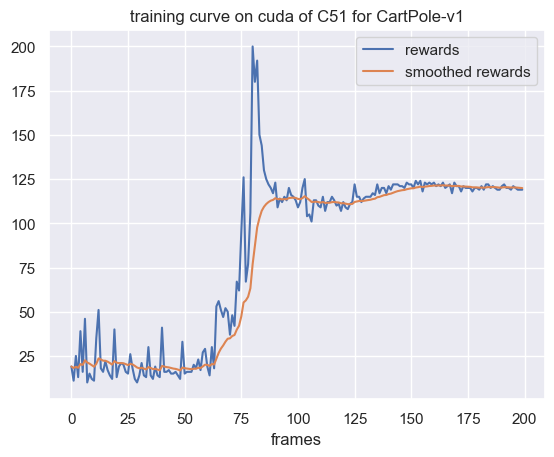

In [30]:
# 获取参数
cfg = Config() 
env = make_env(cfg) # 创建环境
policy = Policy(cfg)
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg, env, policy) # 训练
plot_rewards(cfg, res['frames'], res['rewards'])

### 定义测试

In [31]:
def test(cfg, env, policy: Policy):
    ''' 测试
    '''
    rewards = []  # 记录所有回合的奖励
    frames = []
    for i_ep in range(cfg.max_epsiode_test):
        ep_reward = 0  # 记录一回合内的奖励
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_step):
            action = policy.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        frames.append(i_ep)
        print(f"回合：{i_ep+1}/{cfg.max_epsiode_test}，奖励：{ep_reward:.2f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}
cfg.mode = 'test' # 测试模式
test_env = make_env(cfg)
test_policy = Policy(cfg)
test_policy.load_policy_params(res['best_policy_params']) # 加载训练时的最佳策略参数
test_res = test(cfg, test_env, test_policy)
plot_rewards(cfg, test_res['frames'], test_res['rewards'])

AttributeError: 'Policy' object has no attribute 'load_policy_params'